In [1]:
%%HTML
<style>
.container { width:100% }
</style>

# A Backtracking Solver with Constraint Propagation

## Utility Functions

The module `extractVariables` implements the function $\texttt{extractVars}(e)$ that takes a *Python* expression $e$ as its argument and returns the set of all variables and function names occurring in $e$.

In [2]:
import extractVariables as ev

The function `collect_variables(expr)` takes a string `expr` that can be interpreted as a Python expression as input and collects all variables occurring in `expr`.  It takes care to eliminate the function symbols from the names returned by `extract_variables`.

In [3]:
def collect_variables(expr):
    return frozenset(var for var in ev.extractVars(expr)
                         if  var not in dir(__builtins__)
                    )

The function `arb(S)` takes a set `S` as input and returns an arbitrary element from 
this set.

In [4]:
def arb(S):
    for x in S:
        return x

Backtracking is simulated by raising the `Backtrack` exception.  We define this new class of exceptions so that we can distinguish `Backtrack` exceptions from ordinary exceptions.  This is done by creating a new, empty class that is derived from the class `Exception`.  

In [5]:
class Backtrack(Exception):
    pass

## The Constraint Propagation Solver

The procedure `solve(P)` takes a a <b style="color:blue">constraint satisfaction problem</b> 
`P` as input.  Here `P` is a triple of the form 
$$ \mathcal{P} = \langle \mathtt{Variables}, \mathtt{Values}, \mathtt{Constraints} \rangle $$
where 
- $\mathtt{Variables}$ is a set of strings which serve as <b style="color:blue">variables</b>,
- $\mathtt{Values}$ is a set of <b style="color:blue">values</b> that can be assigned 
  to the variables in the set $\mathtt{Variables}$.
- $\mathtt{Constraints}$ is a set of <b style="color:blue">formulas</b> from first order logic.  
  Each of these formulas is  called a <b style="color:blue">constraint</b> of $\mathcal{P}$.
  
The function `solve` converts the CSP `P` into an <b style="color:blue">augmented CSP</b> where every constraint $f$ is annotated with the variables occurring in $f$.  The most important data structure maintained by `solve` is the dictionary `ValuesPerVar`.  For every variable $x$ occurring in a constraint of `P`, the expression $\texttt{ValuesPerVar}(x)$ is the set of values that can be used to instantiate the variable $x$.  Initially, 
$\texttt{ValuesPerVar}(x)$ is set to `Values`, but as the search for a solution proceeds, the sets $\texttt{ValuesPerVar}(x)$ are reduced by removing any values that cannot be part of a solution.

Next, it divides the constraints into two groups:
- The <em style="color:blue">unary</em> constraints are those constraint that contain only a single variable.

  The unary constraints are immediately solved: If $f$ is a unary constraint containing only the variable $x$, the set $\texttt{ValuesPerVar}(x)$ is reduced to the set of those values $v$ such that $f[x\mapsto v]$ is true.
- The remaining constraints contain at least two different variables.

After the unary constraints have been taken care of, `backtrack_search` is called to solve the remaining constraint satisfaction problem.

In [6]:
def solve(P):
    Variables, Values, Constraints = P
    Annotated    = { (f, collect_variables(f)) for f in Constraints }
    ValuesPerVar = { v: Values for v in Variables }
    UnaryConstrs = { (f, V) for f, V in Annotated
                            if  len(V) == 1
                   }
    OtherConstrs = { (f, V) for f, V in Annotated
                            if  len(V) >= 2
                   }
    try:
        for f, V in UnaryConstrs:
            var = arb(V)
            ValuesPerVar[var] = solve_unary(f, var, ValuesPerVar[var])
        return backtrack_search({}, ValuesPerVar, OtherConstrs)
    except Backtrack:
        return None

The function `solve_unary` takes a unary constraint `f`, a variable `x` and the set of values `Values` that can be assigned to `x`.  It returns the subset of values that can be substituted for `x` such that $f[x\mapsto v]$ evaluates as `True`.

In [7]:
def solve_unary(f, x, Values):
    Legal = { value for value in Values 
                    if  eval(f, { x: value })
            }
    if len(Legal) == 0:
        raise Backtrack()
    return Legal

The function `backtrack_search` takes three arguments:
- `Assignment` is a partial variable assignment that is represented as a
   dictionary.  Initially, this assignment will be the  empty dictionary.     
   Every recursive call of `backtrack_search` adds the assignment of one 
   variable to  the given assignment. 
- `ValuesPerVar` is a dictionary.  For every variable `x`, `ValuesPerVar[x]` is the set of values that still might be assigned to `x`.
- `Constraints` is a set of pairs of the form `(F, V)` where `F` is a constraint and `V` is the set of variables occurring in `V`.

In [8]:
def backtrack_search(Assignment, ValuesPerVar, Constraints):
    print(Assignment)
    if len(Assignment) == len(ValuesPerVar):
        return Assignment
    x = most_constrained_variable(Assignment, ValuesPerVar)
    for v in ValuesPerVar[x]:
        try:
            if is_consistent(x, v, Assignment, Constraints):
                NewValues = propagate(x, v, Assignment, Constraints, ValuesPerVar)
                NewAssign = Assignment.copy()
                NewAssign[x] = v
                return backtrack_search(NewAssign, NewValues, Constraints)
        except Backtrack:
            continue
    raise Backtrack()

The function `most_constrained_variable` takes two parameters:
- `Assigment` is a *partial variable assignment* that assigns values to variables.  It is represented as a dictionary.
- `ValuesPerVar` is a dictionary that has variables as keys.  For every variable `x`, `ValuesPerVar[x]` is the set of values that be assigned to the variable `x`.
The function returns an unassigned variable `x` such that the number of values in `ValuesPerVar[x]` is minimal among all other unassigned variables.

In [9]:
def most_constrained_variable(Assignment, ValuesPerVar):
    Unassigned = { (x, len(U)) for x, U in ValuesPerVar.items()
                               if  x not in Assignment
                 }
    minSize = min(lenU for x, lenU in Unassigned)
    for x, lenU in Unassigned:
        if lenU == minSize:
            return x

The function `propagate` takes five arguments:
- `x` is a variable,
- `v` is a value that is supposed to be assigned to `x`.
- `Assignment` is a partial assignment that contains assignments for variables that are different from `x`.
- `Constraints` is a set of annotated constraints.
- `ValuesPerVar` is a dictionary assigning sets of values to all variables.  For every unassigned variable `z`,  `ValuesPerVar[z]` is the set of values that still might be assigned to `z`.

The purpose of the function  `propagate` is to compute how the sets `ValuesPerVar[z]` can be shrunk when the value `v` is assigned to the variable `x`.  The dictionary `ValuesPerVar` with appropriately reduced sets `ValuesPerVar[z]` is returned.

In [10]:
def propagate(x, v, Assignment, Constraints, ValuesPerVar):
    ValuesDict = ValuesPerVar.copy()
    ValuesDict[x] = { v }
    BoundVars = set(Assignment.keys())
    for F, Vars in Constraints:
        if x in Vars:
            UnboundVars = Vars - BoundVars - { x }
            if len(UnboundVars) == 1:
                y = arb(UnboundVars)
                Legal = set()
                for w in ValuesDict[y]:
                    NewAssign = Assignment.copy()
                    NewAssign[x] = v
                    NewAssign[y] = w
                    if eval(F, NewAssign):
                        Legal.add(w)
                if len(Legal) == 0:
                    raise Backtrack()
                ValuesDict[y] = Legal
    return ValuesDict

The function $\texttt{is_consistent}(\texttt{var}, \texttt{value}, \texttt{Assignment}, \texttt{csp})$ takes four arguments:
<ol>
    <li>$\texttt{var}$ is a variable that does not occur in $\texttt{Assignment}$,</li>
    <li>$\texttt{value}$ is a value that can be substituted for this variable,</li>
    <li>$\texttt{Assignment}$ is a <b style="color:blue">consistent</b> partial variable assignment.         A partial variable assignment $A$ is <b style="color:blue">consistent</b> if all
        constraints $f$ that contain only variables from the set $\mathtt{dom}(A)$ are satisfied.
    <li>$\texttt{csp}$ is an <b style="color:blue">augmented</b> constraint satisfaction problem.</li>
</ol>
This function returns <tt>True</tt> iff the partial variable assignment 
$$\texttt{Assignment} \cup \{\langle\texttt{var} \mapsto\texttt{value}\rangle\}$$
is consistent with all the constraints occurring in $\texttt{csp}$.

In [11]:
def is_consistent(var, value, Assignment, Constraints):
    NewAssign      = Assignment.copy()
    NewAssign[var] = value
    return all(eval(f, NewAssign) for (f, Vs) in Constraints
                                  if  var in Vs and Vs <= NewAssign.keys()
              )

## Solving the *Eight-Queens-Puzzle*

In [12]:
%run N-Queens-Problem-CSP.ipynb

Variables:   {'V2', 'V3', 'V1', 'V4'}
Values:      {1, 2, 3, 4}
Constraints:
             V3 != V4
             abs(V4 - V1) != 3
             V1 != V3
             V2 != V3
             abs(V4 - V3) != 1
             V2 != V4
             abs(V2 - V1) != 1
             V1 != V4
             abs(V3 - V1) != 2
             V1 != V2
             abs(V4 - V2) != 2
             abs(V3 - V2) != 1


In [13]:
P = create_csp(8)

Backtracking search takes about 10 milliseconds on my desktop to solve the eight queens puzzle.

In [14]:
%%time
Solution = solve(P)
print(f'Solution = {Solution}')

{}
{'V2': 1}
{'V2': 1, 'V4': 2}
{'V2': 1, 'V4': 2, 'V6': 8}
{'V2': 1, 'V4': 2, 'V6': 8, 'V7': 3}
{'V2': 1, 'V4': 2, 'V6': 8, 'V7': 3, 'V8': 5}
{'V2': 1, 'V4': 2, 'V6': 3}
{'V2': 1, 'V4': 2, 'V6': 3, 'V7': 8}
{'V2': 1, 'V4': 2, 'V6': 3, 'V7': 8, 'V8': 4}
{'V2': 1, 'V4': 2, 'V6': 3, 'V7': 7}
{'V2': 1, 'V4': 2, 'V6': 3, 'V7': 7, 'V8': 4}
{'V2': 1, 'V4': 2, 'V6': 3, 'V7': 7, 'V8': 4, 'V1': 6}
{'V2': 1, 'V4': 2, 'V6': 3, 'V7': 7, 'V8': 4, 'V1': 6, 'V3': 5}
{'V2': 1, 'V4': 2, 'V6': 3, 'V7': 7, 'V8': 4, 'V1': 6, 'V3': 5, 'V5': 8}
Solution = {'V2': 1, 'V4': 2, 'V6': 3, 'V7': 7, 'V8': 4, 'V1': 6, 'V3': 5, 'V5': 8}
CPU times: user 13.8 ms, sys: 1.14 ms, total: 14.9 ms
Wall time: 15.1 ms


## Displaying the Solution

In order to have a more convenient view of the solution of the 8 queens
puzzle, we have to install `python-chess`.  After activating the appropriate  Python environment, this can be done using the following command:
```
   pip install python-chess
```

In [15]:
import chess

The function `show_solution(Solution)` takes a dictionary that contains a variable assignment that represents a solution to the 8-queens puzzle.  It displays this Solution on a chess board.

In [16]:
def show_solution(Solution):
    board = chess.Board(None)  # create empty chess board
    queen = chess.Piece(chess.QUEEN, True)
    for row in range(1, 8+1):
        col = Solution['V'+str(row)]
        field_number = (row - 1) * 8 + col - 1
        board.set_piece_at(field_number, queen)
    display(board)

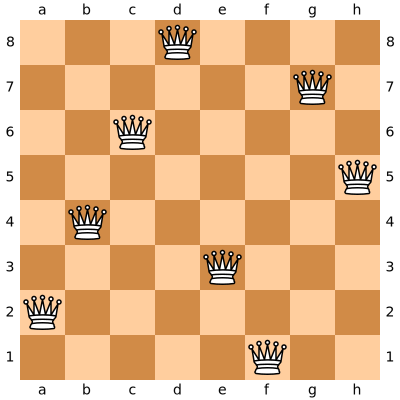

In [17]:
show_solution(Solution)

## Solving the *Zebra Puzzle*

In [18]:
%run Zebra.ipynb

In [19]:
zebra = zebra_csp()

In [20]:
%%time
Solution = solve(zebra)

{}
{'Norwegian': 1}
{'Norwegian': 1, 'Blue': 2}
{'Norwegian': 1, 'Blue': 2, 'Milk': 3}
{'Norwegian': 1, 'Blue': 2, 'Milk': 3, 'Japanese': 2}
{'Norwegian': 1, 'Blue': 2, 'Milk': 3, 'Japanese': 2, 'Parliaments': 2}
{'Norwegian': 1, 'Blue': 2, 'Milk': 3, 'Japanese': 2, 'Parliaments': 2, 'Spanish': 3}
{'Norwegian': 1, 'Blue': 2, 'Milk': 3, 'Japanese': 2, 'Parliaments': 2, 'Spanish': 3, 'Dog': 3}
{'Norwegian': 1, 'Blue': 2, 'Milk': 3, 'Japanese': 2, 'Parliaments': 2, 'Spanish': 3, 'Dog': 3, 'English': 4}
{'Norwegian': 1, 'Blue': 2, 'Milk': 3, 'Japanese': 2, 'Parliaments': 2, 'Spanish': 3, 'Dog': 3, 'English': 4, 'Red': 4}
{'Norwegian': 1, 'Blue': 2, 'Milk': 3, 'Japanese': 2, 'Parliaments': 2, 'Spanish': 3, 'Dog': 3, 'English': 4, 'Red': 4, 'Ukrainian': 5}
{'Norwegian': 1, 'Blue': 2, 'Milk': 3, 'Japanese': 2, 'Parliaments': 2, 'Spanish': 3, 'Dog': 3, 'English': 4, 'Red': 4, 'Ukrainian': 5, 'Tea': 5}
{'Norwegian': 1, 'Blue': 2, 'Milk': 3, 'Japanese': 2, 'Parliaments': 2, 'Spanish': 3, 'Dog': 

In [21]:
show_solution(Solution)

House,Nationality,Drink,Animal,Brand,Colour
1,Norwegian,Water,Fox,Kools,Yellow
2,Ukrainian,Tea,Horse,Chesterfields,Blue
3,English,Milk,Snails,OldGold,Red
4,Spanish,OrangeJuice,Dog,LuckyStrike,Ivory
5,Japanese,Coffee,Zebra,Parliaments,Green


## Solving a Sudoku Puzzle

In [22]:
%run Sudoku.ipynb

In [23]:
csp = sudoku_csp(Sudoku)
csp

({'V11',
  'V14',
  'V15',
  'V16',
  'V17',
  'V18',
  'V21',
  'V22',
  'V23',
  'V25',
  'V26',
  'V31',
  'V32',
  'V33',
  'V34',
  'V37',
  'V41',
  'V42',
  'V43',
  'V45',
  'V49',
  'V51',
  'V52',
  'V53',
  'V54',
  'V56',
  'V58',
  'V59',
  'V63',
  'V64',
  'V65',
  'V66',
  'V67',
  'V68',
  'V69',
  'V71',
  'V72',
  'V75',
  'V77',
  'V78',
  'V81',
  'V84',
  'V85',
  'V86',
  'V87',
  'V89',
  'V92',
  'V93',
  'V94',
  'V95',
  'V96',
  'V98',
  'V99'},
 {1, 2, 3, 4, 5, 6, 7, 8, 9},
 {'1 != V23',
  '1 != V33',
  '1 != V43',
  '1 != V49',
  '1 != V53',
  '1 != V59',
  '1 != V63',
  '1 != V69',
  '1 != V71',
  '1 != V72',
  '1 != V75',
  '1 != V77',
  '1 != V78',
  '1 != V81',
  '1 != V84',
  '1 != V85',
  '1 != V86',
  '1 != V87',
  '1 != V89',
  '1 != V92',
  '1 != V93',
  '1 != V98',
  '1 != V99',
  '2 != V14',
  '2 != V17',
  '2 != V18',
  '2 != V21',
  '2 != V22',
  '2 != V23',
  '2 != V25',
  '2 != V26',
  '2 != V32',
  '2 != V34',
  '2 != V37',
  '2 != V41',
  

In [24]:
%%time
Solution = solve(csp)

{}
{'V37': 1}
{'V37': 1, 'V17': 6}
{'V37': 1, 'V17': 6, 'V18': 5}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9, 'V78': 3}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9, 'V78': 3, 'V77': 7}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9, 'V78': 3, 'V77': 7, 'V87': 9}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9, 'V78': 3, 'V77': 7, 'V87': 9, 'V67': 3}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9, 'V78': 3, 'V77': 7, 'V87': 9, 'V67': 3, 'V68': 1}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9, 'V78': 3, 'V77': 7, 'V87': 9, 'V67': 3, 'V68': 1, 'V64': 8}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9, 'V78': 3, 'V77': 7, 'V87': 9, 'V67': 3, 'V68': 1, 'V64': 8, 'V75': 8}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9, 'V78': 3, 'V77': 7, 'V87': 9, 'V67': 3, 'V68': 1, 'V64': 8, 'V75': 8, 'V58': 6}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9, 'V78': 3, 'V77': 7, 'V87': 9, 'V67': 3, 'V68': 1, 'V64': 8, 'V75': 8, 'V58': 6, 'V72': 4}
{'V37': 1, 'V17': 6, 'V18': 5, 'V34': 9, 'V78': 3, 'V77': 7, 'V87': 9, 'V6

In [25]:
show_solution(Solution)

|| 1 | 3 | 9 || 4 | 2 | 8 || 6 | 5 | 7 || 
-----------------------------------------
|| 6 | 5 | 8 || 7 | 3 | 1 || 4 | 9 | 2 || 
-----------------------------------------
|| 2 | 4 | 7 || 9 | 6 | 5 || 1 | 8 | 3 || 
|| 8 | 1 | 4 || 6 | 9 | 3 || 2 | 7 | 5 || 
-----------------------------------------
|| 9 | 7 | 3 || 5 | 4 | 2 || 8 | 1 | 6 || 
-----------------------------------------
|| 5 | 6 | 2 || 1 | 8 | 7 || 9 | 3 | 4 || 
|| 4 | 8 | 5 || 2 | 7 | 9 || 3 | 6 | 1 || 
-----------------------------------------
|| 3 | 2 | 1 || 8 | 5 | 6 || 7 | 4 | 9 || 
-----------------------------------------
|| 7 | 9 | 6 || 3 | 1 | 4 || 5 | 2 | 8 || 


## Solving a Crypto-Arithmetic Puzzle

In [30]:
%run Crypto-Arithmetic.ipynb

In [31]:
csp = crypto_csp()

In [32]:
%%time
Solution = solve(csp)

{}
{'C3': 0}
{'C3': 0, 'C2': 0}
{'C3': 0, 'C2': 0, 'C1': 0}
{'C3': 0, 'C2': 0, 'C1': 0, 'S': 9}
{'C3': 0, 'C2': 0, 'C1': 0, 'S': 9, 'M': 1}
{'C3': 0, 'C2': 0, 'C1': 0, 'S': 9, 'M': 1, 'O': 0}
{'C3': 0, 'C2': 0, 'C1': 1}
{'C3': 0, 'C2': 0, 'C1': 1, 'S': 9}
{'C3': 0, 'C2': 0, 'C1': 1, 'S': 9, 'M': 1}
{'C3': 0, 'C2': 0, 'C1': 1, 'S': 9, 'M': 1, 'O': 0}
{'C3': 0, 'C2': 1}
{'C3': 0, 'C2': 1, 'C1': 0}
{'C3': 0, 'C2': 1, 'C1': 0, 'S': 9}
{'C3': 0, 'C2': 1, 'C1': 0, 'S': 9, 'M': 1}
{'C3': 0, 'C2': 1, 'C1': 0, 'S': 9, 'M': 1, 'O': 0}
{'C3': 0, 'C2': 1, 'C1': 0, 'S': 9, 'M': 1, 'O': 0, 'E': 2}
{'C3': 0, 'C2': 1, 'C1': 0, 'S': 9, 'M': 1, 'O': 0, 'E': 3}
{'C3': 0, 'C2': 1, 'C1': 0, 'S': 9, 'M': 1, 'O': 0, 'E': 4}
{'C3': 0, 'C2': 1, 'C1': 0, 'S': 9, 'M': 1, 'O': 0, 'E': 5}
{'C3': 0, 'C2': 1, 'C1': 0, 'S': 9, 'M': 1, 'O': 0, 'E': 6}
{'C3': 0, 'C2': 1, 'C1': 0, 'S': 9, 'M': 1, 'O': 0, 'E': 7}
{'C3': 0, 'C2': 1, 'C1': 1}
{'C3': 0, 'C2': 1, 'C1': 1, 'S': 9}
{'C3': 0, 'C2': 1, 'C1': 1, 'S': 9, 'M': 1}
{

In [33]:
show_solution(Solution)

S = 9
Y = 2
E = 5
O = 0
M = 1
N = 6
R = 8
D = 7

The solution of

    S E N D
  + M O R E
  ---------
  M O N E Y

is as follows

    9 5 6 7
  + 1 0 8 5
  1 0 6 5 2
